# Assignment 2: Scale-Space Blob Detection

### The goal of this assignment is to implement a Laplacian blob detector

Noel Mrowiec
10/1/2024
mrowiec3

In [19]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps 
# for applying the Laplacian filter
from scipy.ndimage.filters import gaussian_laplace, maximum_filter

/tmp/ipykernel_63304/681115042.py:9: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter
/tmp/ipykernel_63304/681115042.py:9: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace, maximum_filter


In [20]:
# Function to globally normalize a 2D array to the range [0, 1] 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [21]:

# load each image 
dir_path = "images/"
images = []     #color images
filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
        filenames.append(filename)
        img_path = os.path.join(dir_path, filename)
        img = Image.open(img_path)
        #img.show()  # This will display the image
        
        # convert images to grayscale
        img_gs = ImageOps.grayscale(img) 
        #img_gs.show()
        img_gs = np.array(img_gs).astype(float)
        img_gs = normalize(img_gs)
        images.append(img_gs)
        

print(f"Loaded {len(images)} images")

Loaded 4 images


In [22]:
def get_sigma(k):
    return (2 ** k)

In [23]:

def laplacian_gaussian(image, sigmas):
    scale_space = np.empty((image.shape[0],image.shape[1], len(sigmas)))

    for k, sigma in enumerate(sigmas):
        #sigma = get_sigma(k)
        lap_gaus = gaussian_laplace(image, sigma, mode='nearest') 
        scale_norm_LoG = (sigma ** 2) * lap_gaus                                                      #scale normalized
        scale_space[:,:,k] = scale_norm_LoG

    return scale_space

In [24]:
import numpy as np
from scipy.ndimage import gaussian_laplace, maximum_filter

# Example image
image = np.random.rand(10, 10)
sigmas = range(1, 5)  # Sigma values from 1 to 11

print(image)

# Create a 3D scale space
scale_space = np.stack([gaussian_laplace(image, sigma=sigma) for sigma in sigmas], axis=-1)

# Non-maximum suppression in 3D
footprint = np.ones((3, 3, 3))
local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

# Get coordinates of the local maxima
coordinates = np.argwhere(local_maxima)

# Print the coordinates and corresponding sigma
for coord in coordinates:
    x, y, z = coord
    sigma = sigmas[z]
    print(f"Local maxima at (x={x}, y={y}) with sigma={sigma}")



[[1.97208318e-01 9.41647270e-01 3.38321040e-01 9.05543202e-01
  3.58089965e-01 4.63577690e-01 6.29797260e-01 1.01516620e-01
  5.41925845e-01 4.17794623e-01]
 [3.33265280e-01 1.78258397e-01 5.01957873e-01 4.34101045e-01
  5.30802540e-02 2.01816182e-01 8.75081872e-01 8.38998651e-01
  5.57385584e-01 2.19428101e-01]
 [6.08538077e-01 8.70737975e-01 8.84615415e-01 8.28330749e-01
  3.00860557e-01 6.76048811e-01 4.16226691e-01 8.93807070e-01
  7.31022221e-01 4.30284824e-01]
 [2.30388707e-01 2.54740029e-01 2.59922227e-01 6.81532200e-01
  6.24375300e-01 2.71192819e-01 9.83419880e-01 9.60348511e-01
  1.59765248e-01 6.78380298e-01]
 [9.46606561e-02 3.76180886e-02 8.34758009e-01 3.19982653e-01
  4.11321975e-01 8.50990973e-04 5.84656642e-01 7.08809380e-01
  7.18145287e-01 6.65422567e-01]
 [8.57044850e-01 6.48234563e-01 1.57497407e-01 7.42402488e-01
  6.75458446e-01 5.84200599e-01 1.90559289e-01 5.18209689e-01
  5.77694174e-01 8.98361614e-01]
 [1.45272970e-01 1.06606344e-01 9.70240596e-01 3.72608772e

In [25]:
from scipy.ndimage.filters import rank_filter

def non_max_suppression(array, threshold):
    local_max = rank_filter(array, rank=-1, size=13)

    # Only keep the pixels that are local maxima
    result = np.where(array == local_max, array, 0)

    #suppress any result less than threshold
    result = np.where(result < threshold, 0, array)
    return result

/tmp/ipykernel_63304/1999998974.py:1: DeprecationWarning: Please import `rank_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import rank_filter


In [26]:
def threshold_scale_space(lap_of_gauss, threshold):
    #suppress any result less than threshold
    result = np.where(lap_of_gauss < threshold, 0, lap_of_gauss)
    return result

In [27]:
# #TODO remove
# from skimage import feature
# def get_local_peak_coord(stacked_images):

#     lm = feature.peak_local_max(stacked_images, threshold_abs=10, footprint=np.ones((3, 3, 3)), threshold_rel=10, exclude_border=True)
#     return lm[0], lm[1]

In [28]:
# def get_xy_coordinates(image):
#     # Non-maximum suppression in 3D
#     footprint = np.ones((3, 3, 3))
#     local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

#     # Get coordinates of the local maxima
#     coordinates = np.argwhere(local_maxima)

#     # Print the coordinates and corresponding sigma
#     for coord in coordinates:
#         x, y, z = coord
#         sigma = sigmas[z]
#         print(f"Local maxima at (x={x}, y={y}) with sigma={sigma}"


In [29]:
def non_max_suppression_3d(scale_space, sigmas, window_size = 5):

    # Non-maximum suppression in 3D
    footprint = np.ones((window_size, window_size, len(sigmas)))
    local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

    return local_maxima

In [30]:
def get_maxima_coords(local_maxima, threshold):
    """
    returns: a list of coordinates of local maxima (x,y,sigma)
    """
    # Get coordinates of the local maxima
    coordinates = np.argwhere(local_maxima)
    
    x_coords, y_coords, z_coords = [], [], []
    # Filter coordinates by the threshold

    #source: Copilot
    for coord in coordinates:
        if local_maxima[tuple(coord)] > threshold:
            h, w, d = coord
            x_coords.append(int(w))
            y_coords.append(int(h))
            z_coords.append(int(d))


    return [x_coords, y_coords, z_coords]

In [31]:
# constant
sqt_2 = 2**(1/2)
type(sqt_2)

float

In [32]:
#N = 10
SIGMAS = [1,2,4,8,16,32]
coordinates_per_image = []

mean_percent = 1

for image in images:
    lap_of_gauss = laplacian_gaussian(image, SIGMAS)
    #take absolute value
    lap_of_gauss = np.abs(lap_of_gauss)

    #threshold scale space
    threshold = np.percentile(lap_of_gauss, 95)
    # lap_of_gauss = threshold_scale_space(lap_of_gauss, threshold)

    #3D non-maximum suppression
    WINDOW_SIZE = 5
    local_maxima = non_max_suppression_3d(lap_of_gauss, SIGMAS, WINDOW_SIZE)
    coordinates = get_maxima_coords(local_maxima, threshold)
    coordinates_per_image.append(coordinates)

    # for k, sigma in enumerate(SIGMAS):
       
    #     #non_max_suppressed = non_max_suppression(lap_of_gauss[:,:, k], threshold)

    #     # Convert to Pandas DataFrame
    #     # df = pd.DataFrame(non_max_suppressed)

    #     # print(df.describe())


    #     #h_pos, w_pos = get_xy_coordinates(non_max_suppressed)
    #     h_pos, w_pos = get_local_peak_coord()

    #     x_coordinates = np.append(x_coordinates, w_pos)
    #     y_coordinates = np.append(y_coordinates, h_pos)

    #     radii = np.append(radii, np.full(h_pos.shape[0], sigma * sqt_2))       # TODO divide by sigma squared?




In [33]:





# filtering the image (two implementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()



# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful



# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cy))

    plt.show()

image size (356, 493)
num of images 4
x :<class 'int'>, y <class 'int'>, radii <class 'float'>


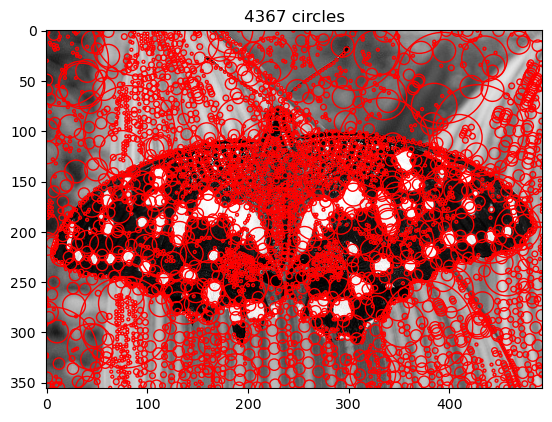

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


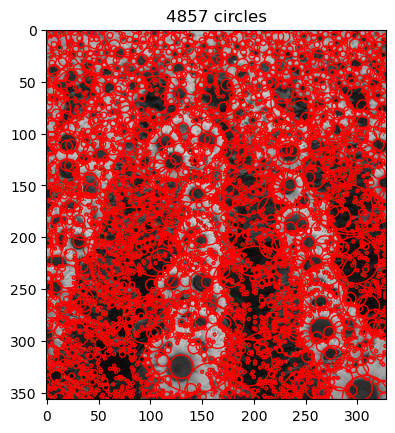

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


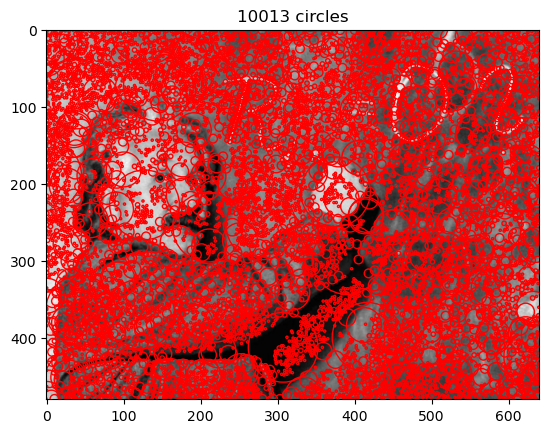

x :<class 'int'>, y <class 'int'>, radii <class 'float'>


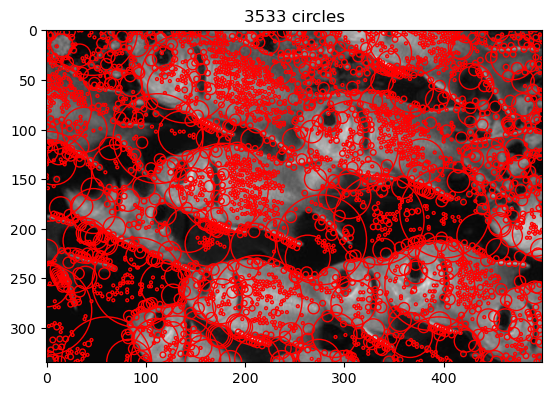

In [34]:
#np.set_printoptions(threshold=np.inf)

print(f"image size {images[0].shape}")
print(f"num of images {len(coordinates_per_image)}")

for i, coords in enumerate(coordinates_per_image):
   
    cx, cy, cz = coords
    sigmas = np.array([SIGMAS[z] for z in cz])
    radii = sigmas * sqt_2
    radii = radii.tolist()

    print(f"x :{type(cx[0])}, y {type(cy[0])}, radii {type(radii[0])}")
    show_all_circles(images[i], cx, cy, radii)
#show_all_circles(images[0], [55,33,88,10], [76,350,12,100], [5,7,1,2])

In [35]:
import numpy as np
from scipy.ndimage import gaussian_laplace, maximum_filter

# Example image and sigma values
image = np.random.rand(100, 100)
sigmas = range(1, 12)  # Sigma values from 1 to 11

# Create a 3D scale space
scale_space = np.stack([gaussian_laplace(image, sigma=sigma) for sigma in sigmas], axis=-1)

# Calculate the 80th percentile value
threshold = np.percentile(scale_space, 80)

# Non-maximum suppression in 3D
footprint = np.ones((3, 3, 3))
local_maxima = (scale_space == maximum_filter(scale_space, footprint=footprint))

# Get coordinates of the local maxima
coordinates = np.argwhere(local_maxima)

# Filter coordinates by the threshold
filtered_coords = [coord for coord in coordinates if scale_space[tuple(coord)] > threshold]

# Print the filtered coordinates and corresponding sigma
for coord in filtered_coords:
    print(coord)
    x, y, z = coord
    sigma = sigmas[z]
    print(f"Local maxima at (x={x}, y={y}) with sigma={sigma} and value={scale_space[tuple(coord)]}")



[0 0 0]
Local maxima at (x=0, y=0) with sigma=1 and value=0.24161588738383608
[0 9 0]
Local maxima at (x=0, y=9) with sigma=1 and value=0.09688188380236626
[ 0 16  0]
Local maxima at (x=0, y=16) with sigma=1 and value=0.23937717773776035
[ 0 25  0]
Local maxima at (x=0, y=25) with sigma=1 and value=0.16327924066912952
[ 0 34  0]
Local maxima at (x=0, y=34) with sigma=1 and value=0.23901319702824167
[ 0 38  0]
Local maxima at (x=0, y=38) with sigma=1 and value=0.0779168516589497
[ 0 41  0]
Local maxima at (x=0, y=41) with sigma=1 and value=0.2187041948925926
[ 0 45  0]
Local maxima at (x=0, y=45) with sigma=1 and value=0.20787649324051338
[ 0 52  0]
Local maxima at (x=0, y=52) with sigma=1 and value=0.19754227562936713
[ 0 56  0]
Local maxima at (x=0, y=56) with sigma=1 and value=0.1904254277367888
[ 0 75  0]
Local maxima at (x=0, y=75) with sigma=1 and value=0.16522696808302023
[ 0 77  0]
Local maxima at (x=0, y=77) with sigma=1 and value=0.12599994944386952
[ 0 87  0]
Local maxima at 

In [36]:
import cv2
import numpy as np

# Load your image
image = cv2.imread('images/butterfly.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)

# Print the radius (scale) of each keypoint
for kp in keypoints:
    print(f"Keypoint radius: {kp.size}")

print(f"number of keypoints {len(keypoints)}")


Keypoint radius: 7.039892673492432
Keypoint radius: 7.039892673492432
Keypoint radius: 9.89643383026123
Keypoint radius: 9.89643383026123
Keypoint radius: 9.936521530151367
Keypoint radius: 8.38396167755127
Keypoint radius: 11.6674165725708
Keypoint radius: 11.6674165725708
Keypoint radius: 10.20260238647461
Keypoint radius: 10.20260238647461
Keypoint radius: 5.025646686553955
Keypoint radius: 5.977290153503418
Keypoint radius: 8.488493919372559
Keypoint radius: 5.123463153839111
Keypoint radius: 5.123463153839111
Keypoint radius: 8.046290397644043
Keypoint radius: 9.387319564819336
Keypoint radius: 9.387319564819336
Keypoint radius: 7.613601207733154
Keypoint radius: 17.341140747070312
Keypoint radius: 14.746243476867676
Keypoint radius: 9.3104887008667
Keypoint radius: 14.199297904968262
Keypoint radius: 6.085587024688721
Keypoint radius: 6.085587024688721
Keypoint radius: 7.732848644256592
Keypoint radius: 9.687704086303711
Keypoint radius: 5.872124195098877
Keypoint radius: 9.58001